# Fitting Code Explanation

Written 18 Nov 2024 by Menelaos Raptis with edits by Ryan Trainor

This notebook contains the code for the fitting procedure. Below are the required inputs:

- **Wavelength array (`lams`)**
- **1D spectrum (`flux`)**
- **Flux error array (`flux_error`)**

Note that the code also requires installing the LMFIT library (https://lmfit.github.io/lmfit-py/)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
from lmfit.models import GaussianModel,PolynomialModel,QuadraticModel
from lmfit.parameter import Parameter

def fitSpectrum(lams, flux, flux_error, linelist, z_init=0, weights=None, showPlot=False):
    
    # check if arrays are astropy quantities and strip units if so
    if hasattr(lams, 'value'):
        lams = lams.value
    if hasattr(flux, 'value'):
        flux = flux.value
    if hasattr(flux_error, 'value'):
        flux_error = flux_error.value

    #Create gaussian profiles for each one of the emission lines:
    gaussians = []
    for i, label in enumerate(linelist.keys()):
        gaussian = GaussianModel(prefix=label+'_')
        gaussians.append(gaussian)

    #Create a polynomial model for the continuum
    polydeg=5
    polynomial = PolynomialModel(degree=polydeg)

    #Combine Gaussian models into a composite model
    sum_of_gaussians = gaussians[0]
    for gaussian in gaussians[1:]:
        sum_of_gaussians += gaussian

    comp_mult = sum_of_gaussians + polynomial
    pars_mult = comp_mult.make_params()

    pars_mult.add(name='z', value=z_init)

    #Add the 'sigma_v' parameter to tie all the sigmas together
    pars_mult.add(name='sigma_v', value=70, min=30)

    # for label, lam in zip(line_labels, line_lams):
    for label in linelist.keys():
        lam = linelist[label]
        for param in ['center', 'amplitude', 'sigma']:
            key = f'{label}_{param}'
            if param == 'center':
                value = lam
                vary = True
                min_value = None
                expr = f'{lam:6.2f}*(1+z)'
            elif param == 'amplitude':
                value = 1
                vary = True
                min_value = None
                expr = None
            elif param == 'sigma':
                vary = True
                min_value = None
                expr = f'(sigma_v/3e5)*{label}_center'
            pars_mult[key] = Parameter(name=key, value=value, min=min_value, vary=vary, expr=expr)

    # Manually perform the tying where needed (these relationships come from Quantum Mechanics)
    pars_mult['O3_4959_amplitude'].set(expr='O3_5008_amplitude/3')
    pars_mult['O3_5008_sigma'].set(expr='(O3_4959_sigma * O3_5008_center) / O3_4959_center')
    pars_mult['N2_6550_sigma'].set(expr='(N2_6585_sigma * N2_6550_center) / N2_6585_center')
    pars_mult['N2_6550_amplitude'].set(value=0.12, min=0, expr='N2_6585_amplitude/3')

    #Polynomial continuum
    for i in range(polydeg+1):
        pars_mult[f'c{i:1.0f}'].set(value=0)

    if weights is None:
        out_comp_mult = comp_mult.fit(flux, pars_mult, x=lams, nan_policy='omit')
    else:
        out_comp_mult = comp_mult.fit(flux, pars_mult, x=lams, weights=weights, nan_policy='omit')

    if showPlot:
        fig = plot_spec_fit(lams, flux, flux_error, linelist, z=None, model=out_comp_mult)

    return out_comp_mult

def plot_spec_fit(lams, flux, flux_error, linelist, z=None, model=None):
    if z is None:
        if model is not None:
            z = model.params['z'].value
        else: z=0
    
    fig,ax=plt.subplots(figsize=(8, 4))
    ax.plot(lams, flux, lw=1, drawstyle='steps-mid', label = 'Observed spectrum')
    ax.fill_between(lams, -flux_error, flux_error, label = 'Error spectrum',zorder=-2,color='0.6')
    ax.axhline(0,color='k',ls='-',zorder=-1)
    if model is not None:
        ax.plot(lams, model.best_fit, '-', lw=0.5, label='Best-fit model')

    ax.set_xlabel('Obs. Wavelength ($\AA$)',size=14)
    ax.set_ylabel('Flux (MJy)',size=14)
    ax.set_xlim([np.min(lams),np.max(lams)])

    xlim = ax.get_xlim()
    # buff = 0.001*(xlim[1]-xlim[0])
    for label in linelist.keys():
        obs_lam = linelist[label] * (1+z)
        ax.axvline(obs_lam, linestyle='--', linewidth=1, color='k', lw=0.5) # , label=label
        ax.text(obs_lam,0.99,'\n'+label,rotation=90,ha='center',va='top',color='k',size=8,transform=ax.get_xaxis_transform())
    ax.legend()
    fig.tight_layout()

    return fig


### Rescaling Flux Uncertainties with the IQR Method
This code rescales flux uncertainties to improve reliability by accounting for outliers in the residuals. The IQR method identifies outliers in the scaled residuals (residuals normalized by flux errors) using the interquartile range (IQR = Q3 - Q1). Outliers are values outside `[Q1 - 1.8 * IQR, Q3 + 1.8 * IQR]` and are excluded when calculating the scaling factor.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_updated_error_spectrum(flux, model_spectrum, flux_error, wht_1D): #wht_1D is the 1D weight array!
    #Calculate the residuals between the flux and model spectrum
    residual = flux - model_spectrum
    

    #Calculate the scaled residuals
    scaled_residual = residual / flux_error

    
    #Get the valid pixels based on wht_1D > 0
    valid_pixels = np.where(wht_1D > 0)[0]
    scaled_residual_valid = scaled_residual[valid_pixels]
    
    #Use masked array to ignore NaN values
    scaled_residual_valid = np.ma.masked_invalid(scaled_residual_valid)
    


    # Calculate the lower and upper bounds for outlier removal
    q1 = np.percentile(scaled_residual_valid.compressed(), 25)
    q3 = np.percentile(scaled_residual_valid.compressed(), 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.8 * iqr
    upper_bound = q3 + 1.8 * iqr
    

    #Apply the outlier filter
    filtered_residuals = scaled_residual_valid[(scaled_residual_valid >= lower_bound) &
                                               (scaled_residual_valid <= upper_bound)]

    
    #Calculate the scaling factor as the standard deviation of filtered_residuals
    scaling_factor = np.ma.std(filtered_residuals)
    
    print("The scaling factor for the error is: ", scaling_factor)

    #Scale the flux error
    scaled_flux_error = flux_error * scaling_factor

    return scaled_flux_error

With the scaled flux errors, we use Monte Carlo realizations to quantify uncertainties in the flux measurements. This involves generating multiple synthetic spectra by adding random Gaussian noise, scaled by the updated flux errors, to the 1D spectrum. For each synthetic spectrum, the emission lines are fitted, and the parameter values (flux, width, and center position) are recorded. Repeating this process 400 times creates a distribution of parameter values for each emission line, with the standard deviation of these distributions providing the flux uncertainty estimate for each line.

In [ ]:
def fitSpectrumMC(lams, flux, scaled_flux_error, linelist, z_init=0.1, weights=None, numMC=400):
    dists = {}  # Initialize an empty dictionary to store parameter values
    for i in range(numMC):
        # Create a data set with random offsets scaled by uncertainties
        yoff = flux + np.random.randn(len(flux)) * scaled_flux_error
        fit = fitSpectrum(lams, yoff, scaled_flux_error, linelist=linelist, z_init=z_init, weights=weights)  # Use yoff instead of flux
        #Store the parameter values
        for nm in fit.params:
            if nm not in dists:
                dists[nm] = []  #Initialize an empty list for each parameter name
            dists[nm].append(fit.params[nm].value)
            
    return dists  #Return the dists dictionary after the loop

The cell below shows an example of the fitting script in use:

In [ ]:
%matplotlib widget

# read in linelist and define dictionary
linelist_table = ascii.read('/Users/javieratoro/Desktop/proyecto 2024-2/emission_lines.csv')
#linelist_table = ascii.read('/Users/javieratoro/Desktop/proyecto 2024-2/cecilia/cecilia_linelist.txt')
linelist_dict = {}
for line in linelist_table:
    linelist_dict[line['name']] = line['vacuum_wave']

# read in spectrum
J0021 = ascii.read('/Users/javieratoro/Desktop/proyecto 2024-2/cecilia/J0021.csv')

idx = (J0021['wave']>3700)&(J0021['wave']<1.1e4)
wave = J0021['wave'][idx]
flux = J0021['flux'][idx]
noise= J0021['noise'][idx]

from scipy.ndimage import gaussian_filter1d
sm_noise = gaussian_filter1d(noise,sigma=25)

# fit spectrum
fit = fitSpectrum(wave, flux, noise, linelist=linelist_dict, z_init=0.098, weights=1/sm_noise**2, showPlot=True)
print(fit.fit_report())

### Calculate line flux uncertainties using MC method


In [ ]:
# use numMC > 100 for more accurate uncertainties
dists = fitSpectrumMC(wave, flux, noise, linelist=linelist_dict, z_init=0.098, weights=1/noise**2, numMC=2)

In [ ]:
flux_order = -17
print(f'Line fluxes (e{flux_order} erg/s/cm2):')
for label in linelist_dict.keys():
    print(f'{label:10s} {np.mean(dists[label+"_amplitude"])/10**flux_order:7.1f} +/- {np.std(dists[label+"_amplitude"])/10**flux_order:4.1f}')

### Check uncertainties compared to noise in spectrum


In [ ]:
model_spectrum = fit.best_fit
scaled_error = calculate_updated_error_spectrum(flux, model_spectrum, noise, 1/noise**2)

# Draw plot for comparison
resid = flux-model_spectrum
cont_idx = resid==resid
cont_idx[noise==0] = False
dv = fit.params['sigma_v'].value
z = fit.params['z'].value
for label in linelist_dict.keys():
    w = linelist_dict[label] * (1+z)
    cont_idx[np.abs(wave-w)/w < 5*dv/3e5] = False
cont_idx[noise>2*np.median(noise)] = False

fig,axs=plt.subplots(ncols=2,figsize=(8,4))
axs[0].errorbar(wave[cont_idx],resid[cont_idx],noise[cont_idx],alpha=0.5,ls='none',label='Original')
axs[0].errorbar(wave[cont_idx],resid[cont_idx],noise[cont_idx],alpha=0.5,ls='none',label='Scaled')
# axs[0].plot(wave[cont_idx],noise[cont_idx],lw=1,label='Noise')
axs[0].axhline(0,ls='--',color='k')
# axs[0].plot(wave[cont_idx],model_spectrum[cont_idx],'k',lw=1,label='Model')
axs[0].set_xlabel('Obs. Wavelength ($\AA$)')
axs[0].set_ylabel('Flux (MJy)')
axs[0].set_xlim([np.min(wave),np.max(wave)])

axs[1].hist(resid[cont_idx]/noise[cont_idx],density=True,bins=np.linspace(-5,5,101),alpha=0.5,label='Original')
axs[1].hist(resid[cont_idx]/scaled_error[cont_idx],density=True,bins=np.linspace(-5,5,101),alpha=0.5,label='Scaled')
xx=np.linspace(-5,5,300)
axs[1].plot(xx,1/np.sqrt(2*np.pi)*np.exp(-xx**2/2),'k-',label='Gaussian PDF')
for i in range(-4,6,1):
    axs[1].axvline(i,color='k',ls='--',lw=0.5)
axs[1].set_xlim([-5,5])
axs[1].set_xlabel('residuals / $\sigma$')
axs[1].set_ylabel('# pixels')
axs[1].legend()
fig.tight_layout()

# TRYING

In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
from astropy.io import fits, ascii
from astropy.table import Table
import numpy as np
import pandas as pd
from GaussianFitting import fitSpectrum, fitSpectrumMC
from scipy.ndimage import gaussian_filter1d

In [2]:
specobjID = {'J2225': 422244936562272256,
             'J2215': 1243134008619984896,
             'J0240': 513494502204270592,
             'J0021': 439223316213950464,
             'J0950': 300731025703593984,
             'J1146': 318786936665827328,
             'J1226': 3242617920756410368,
             'J1444': 661039343871223808,
             'J1448': 346799464301750272,
             'J2101': 717307953417316352,
             'J2119': 1111371552277948416,
             'J0023': 735339668748396544,
             'J0136': 1691125637219117056,
             'J0252': 797248221209454592,
             'J0305': 798423599642863616,
             'J2212': 1243114217410684928,
             'J2337': 767911057829160960,
             'J1624': 409879001813772288 }

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from lmfit.models import GaussianModel, PolynomialModel
from lmfit.parameter import Parameter
import pandas as pd

def fitBalmer(lams, flux, flux_error, linelist, z_init=0,
                weights=None, showPlot=False, nfev=None):

    if hasattr(lams, 'value'):
        lams = lams.value
    if hasattr(flux, 'value'):
        flux = flux.value
    if hasattr(flux_error, 'value'):
        flux_error = flux_error.value


    balmer_lines = ['H_alpha', 'H_beta', 'H_gamma', 'H_delta',
                    'H_epsilon', 'H_6', 'H_7', 'H_8', 'H_9',
                    'H_10', 'H_11']
    seps = [10, 6, 6, 6, 6, 4, 4, 4, 4, 4, 4]

    end_flux = flux.copy()

    for balmer_key, sep in zip(balmer_lines, seps):
        wave_ = linelist[balmer_key] * (1 + z_init)
        where = [wave_ - sep, wave_ + sep]

        line = flux[(wave > where[0]) & (wave < where[1])]

        start1 = []
        end1 = []
        in_change = False

        for i in range(1, len(line)):
            if np.abs(line[i-1] - line[i]) > 2.0:
                if not in_change:
                    start1.append(i)
                    in_change = True
            else:
                if in_change:
                    end1.append(i)
                    in_change = False

        if in_change:
            end1.append(len(flux) - 1)

        new_flux = line.copy()
        if len(start1) > 0 or len(end1) > 0:
            new_flux[start1[0]:end1[-1]] = np.min(flux[(wave > where[0] + 10 ) & (wave < where[1]) + 10])

        end_flux[(wave > where[0]) & (wave < where[1])] = new_flux

    neg_gaussians = []
    for label in balmer_lines:
        neg_gauss = GaussianModel(prefix=label)
        neg_gaussians.append(neg_gauss)

    polydeg = 5
    polynomial = PolynomialModel(degree=polydeg)

    sum_of_gaussians = neg_gaussians[0]
    for gaussian in neg_gaussians[1:]:
        sum_of_gaussians += gaussian

    comp_mult = sum_of_gaussians + polynomial
    pars_mult = comp_mult.make_params()

    pars_mult.add(name='z', value=z_init)

    pars_mult.add(name='sigma_v', value=100, min=90, max=500)

    for label in balmer_lines:
        lam = linelist[label]
        for param in ['center', 'amplitude', 'sigma']:
            key = f'{label}_{param}'
            if param == 'center':
                value = lam
                vary = True
                min_value = None
                max_value = None
                expr = f'{lam:6.2f}*(1+z)'
            elif param == 'amplitude':
                value = -1
                vary = True
                min_value = None
                max_value = 0
                expr = None
            elif param == 'sigma':
                vary = True
                min_value = None
                max_value = None
                expr = f'(sigma_v/3e5)*{label}_center'
            pars_mult[key] = Parameter(name=key, value=value, min=min_value, max=max_value, vary=vary, expr=expr)
        for i in range(polydeg+1):
            pars_mult[f'c{i:1.0f}'].set(value=0)

    if weights is None:
        out_comp_mult = comp_mult.fit(end_flux, pars_mult, x=lams,
                                      nan_policy='omit', max_nfev=nfev)
    else:
        out_comp_mult = comp_mult.fit(end_flux, pars_mult, x=lams,
                                      weights=weights, nan_policy='omit',
                                      max_nfev=nfev)

    if showPlot:

        fig2, ax = plt.subplots(figsize=(10, 4))
        comps = out_comp_mult.eval_components(x=lams)
        ax.plot(lams, flux, 'grey', lw=1, drawstyle='steps-mid', label='Observed spectrum')
        ax.plot(lams, end_flux, 'black', lw=1, drawstyle='steps-mid', label='line masked spectrum')
        ax.plot(lams, out_comp_mult.best_fit, 'b-', lw=1, drawstyle='steps-mid',
                label='Best model')
        ax.plot(lams, comps['polynomial'], 'r-', label='Polynomial component',
                lw=1, drawstyle='steps-mid', alpha=0.3)
        gaussians = [key for key, _ in comps.items() if not 'polynomial' in key]
        for i, gaussian in enumerate(gaussians):
            if i == len(gaussians) - 1:
                ax.plot(lams, comps[gaussian] + comps['polynomial'],
                        'g--',
                        label='Negative Gaussian component', alpha=0.3)
            else:
                ax.plot(lams, comps[gaussian] + comps['polynomial'], 'g--',
                        alpha=0.3)


        for label in balmer_lines:
            obs_lam = linelist[label] * (1 + float(out_comp_mult.params['z'].value))
            ax.axvline(obs_lam, linestyle='--', linewidth=1, color='k', lw=0.5)
            ax.text(obs_lam, 0.99, '\n'+label, rotation=90, ha='center', va='top',
                    color='k', size=8, transform=ax.get_xaxis_transform())

        ax.set_xlabel(r'Obs. Wavelength ($\AA$)', size=14)
        ax.set_ylabel(r'Flux ($10^{-17} erg/s/cm^{2}/\AA$)', size=14)
        ax.set_xlim([np.min(lams), np.max(lams)])
        ax.legend()
        fig2.tight_layout()

    return out_comp_mult



def fitSpectrum(lams, flux, flux_error, linelist, z_init=0,
                weights=None, showPlot=False, params=None,
                broad=True, nfev=None):

    if hasattr(lams, 'value'):
        lams = lams.value
    if hasattr(flux, 'value'):
        flux = flux.value
    if hasattr(flux_error, 'value'):
        flux_error = flux_error.value

    narrow_gaussians = []
    broad_gaussians = []
    for label in linelist.keys():
        # Narrow component
        narrow_gaussian = GaussianModel(prefix=label+'_narrow_')
        narrow_gaussians.append(narrow_gaussian)

        if broad is True:
            broad_gaussian = GaussianModel(prefix=label+'_broad_')
            broad_gaussians.append(broad_gaussian)

    # Create a polynomial model for the continuum
    polydeg = 5
    polynomial = PolynomialModel(degree=polydeg)

    # Combine models
    if broad is True:
        sum_of_gaussians = broad_gaussians[0] + narrow_gaussians[0]
        for narrow, broad_value in zip(narrow_gaussians[1:],
                                       broad_gaussians[1:]):
            sum_of_gaussians += (broad_value + narrow)
    else:
        sum_of_gaussians = narrow_gaussians[0]
        for gaussian in narrow_gaussians[1:]:
            sum_of_gaussians += gaussian

    comp_mult = sum_of_gaussians + polynomial
    pars_mult = comp_mult.make_params()

    if params is None:
        pars_mult.add(name='z', value=z_init)

        # Add the 'sigma_v' parameter to tie narrow sigmas together
        pars_mult.add(name='sigma_v_narrow', value=50, min=20, max=70)

        # Loop through emission lines to define parameters for narrow and broad
        for label in linelist.keys():
            lam = linelist[label]
            for param in ['center', 'amplitude', 'sigma']:
                narrow_key = f'{label}_narrow_{param}'
                if param == 'center':
                    value = lam
                    vary = True
                    expr = f'{lam:6.2f}*(1+z)'
                elif param == 'amplitude':
                    value = 1
                    vary = True
                    expr = None
                elif param == 'sigma':
                    vary = True
                    expr = f'(sigma_v_narrow/3e5)*{label}_narrow_center'
                pars_mult[narrow_key] = Parameter(name=narrow_key, value=value,
                                                  vary=vary, expr=expr,
                                                  min=0.0)

        bright_lines = ['O2_3725', 'O2_3727', 'H_alpha', 'H_beta', 'H_gamma',
                        'O3_5008', 'O3_4959', 'N2_6550', 'N2_6585', 'S2_6716',
                        'S2_6730']
        if broad is True:
            pars_mult.add(name='sigma_v_broad', value=90, min=70, max=500)

            for label in bright_lines:
                lam = linelist[label]
                for param in ['center', 'amplitude', 'sigma']:
                    broad_key = f'{label}_broad_{param}'
                    if param == 'center':
                        value = lam
                        expr = f'{lam:6.2f}*(1+z)'
                        vary = True
                        expr = f'{lam:6.2f}*(1+z)'
                    elif param == 'amplitude':
                        value = 0.3
                        vary = True
                        expr = None
                    elif param == 'sigma':
                        vary = True
                        expr = f'(sigma_v_broad/3e5)*{label}_broad_center'
                    pars_mult[broad_key] = Parameter(name=broad_key,
                                                     value=value,
                                                     vary=vary, expr=expr)

        for i in range(polydeg+1):
            pars_mult[f'c{i:1.0f}'].set(value=0)

    else:
        pars_mult = params

    if weights is None:
        out_comp_mult = comp_mult.fit(flux, pars_mult, x=lams,
                                      nan_policy='omit', max_nfev=nfev)
    else:
        out_comp_mult = comp_mult.fit(flux, pars_mult, x=lams,
                                      weights=weights, nan_policy='omit',
                                      max_nfev=nfev)

    if showPlot:
        plot_spec_fit(lams, flux, flux_error, linelist, z=None,
                      model=out_comp_mult, broad=broad)

    return out_comp_mult


def plot_spec_fit(lams, flux, flux_error, linelist, z=None, model=None,
                  broad=True):
    if z is None:
        if model is not None:
            z = model.params['z'].value
        else:
            z = 0

    fig2, ax = plt.subplots(figsize=(10, 4))
    comps = model.eval_components(x=lams)
    narrow_key = [key for key, _ in comps.items() if 'narrow' in key]
    ax.plot(lams, flux, lw=1, drawstyle='steps-mid', label='Observed spectrum')
    ax.plot(lams, model.best_fit, lw=1, drawstyle='steps-mid',
            label='Best model')
    ax.plot(lams, comps['polynomial'], 'r-', label='Polynomial component',
            lw=1, drawstyle='steps-mid', alpha=0.3)

    if broad is True:
        broad_key = [key for key, _ in comps.items() if 'broad' in key]
        for i, broad_line in enumerate(broad_key):
            if i == len(broad_key) - 1:
                ax.plot(lams, comps[broad_line] + comps['polynomial'], 'k--',
                        label='Broad component', alpha=0.3)
            else:
                ax.plot(lams, comps[broad_line] + comps['polynomial'], 'k--',
                        alpha=0.3)

    for i, narrow_line in enumerate(narrow_key):
        if i == len(narrow_key) - 1:
            ax.plot(lams, comps[narrow_line] + comps['polynomial'], 'g--',
                    label='narrow component', alpha=0.3)
        else:
            ax.plot(lams, comps[narrow_line] + comps['polynomial'], 'g--',
                    alpha=0.3)

    for label in linelist.keys():
        obs_lam = linelist[label] * (1+z)
        ax.axvline(obs_lam, linestyle='--', linewidth=1, color='k', lw=0.5)
        ax.text(obs_lam, 0.99, '\n'+label, rotation=90, ha='center', va='top',
                color='k', size=8, transform=ax.get_xaxis_transform())

    ax.set_xlabel(r'Obs. Wavelength ($\AA$)', size=14)
    ax.set_ylabel(r'Flux ($10^{-17} erg/s/cm^{2}/\AA$)', size=14)
    ax.set_xlim([np.min(lams), np.max(lams)])
    ax.legend()
    fig2.tight_layout()

    return fig2


def calculate_updated_error_spectrum(flux, model_spectrum, flux_error, wht_1D):
    # wht_1D is the 1D weight array!
    # Calculate the residuals between the flux and model spectrum
    residual = flux - model_spectrum

    # Calculate the scaled residuals
    scaled_residual = residual / flux_error

    # Get the valid pixels based on wht_1D > 0
    valid_pixels = np.where(wht_1D > 0)[0]
    scaled_residual_valid = scaled_residual[valid_pixels]

    # Use masked array to ignore NaN values
    scaled_residual_valid = np.ma.masked_invalid(scaled_residual_valid)

    # Calculate the lower and upper bounds for outlier removal
    q1 = np.percentile(scaled_residual_valid.compressed(), 25)
    q3 = np.percentile(scaled_residual_valid.compressed(), 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.8 * iqr
    upper_bound = q3 + 1.8 * iqr

    # Apply the outlier filter
    filtered_residuals = scaled_residual_valid[(
        scaled_residual_valid >= lower_bound) &
        (scaled_residual_valid <= upper_bound)]

    # Calculate the scaling factor as the standard deviation of
    # filtered_residuals
    scaling_factor = np.ma.std(filtered_residuals)

    print("The scaling factor for the error is: ", scaling_factor)

    # Scale the flux error
    scaled_flux_error = flux_error * scaling_factor

    return scaled_flux_error


def fitSpectrumMC(lams, flux, scaled_flux_error, linelist, z_init=0.1,
                  weights=None, numMC=400, nfev=None,
                  showPlot=False, init_params=None, broad=True):
    dists = {}  # Initialize an empty dictionary to store parameter values

    columns = ['iter', 'n_eval', 'success', 'message', 'ier', 'z',
               'sigma_v_narrow', 'sigma_v_broad']

    bright_lines = ['O2_3725', 'O2_3727', 'H_alpha', 'H_beta',
                    'H_gamma', 'O3_5008', 'O3_4959', 'N2_6550',
                    'N2_6585', 'S2_6716', 'S2_6730']

    for label in linelist:
        columns.append(str(label) + '_narrow')
        if str(label) in bright_lines:
            columns.append(str(label) + '_broad')

    df = pd.DataFrame(columns=columns)


    if init_params is None:
        fit_init = fitSpectrum(lams, flux, scaled_flux_error,
                               linelist=linelist, z_init=z_init,
                               weights=weights, showPlot=showPlot,
                               broad=broad, nfev=nfev)
        init_params = fit_init.params

    for i in range(numMC):
        # Create a data set with random offsets scaled by uncertainties
        yoff = flux + np.random.randn(len(flux)) * scaled_flux_error

        fit = fitSpectrum(lams, yoff, scaled_flux_error,
                          linelist=linelist,
                          z_init=z_init, weights=weights, showPlot=showPlot,
                          params=init_params, broad=broad, nfev=nfev)

        row = {'iter': i + 1,
               'z': float(fit.params['z'].value),
               'sigma_v_narrow': float(fit.params['sigma_v_narrow'].value),
               'sigma_v_broad': -9999.0,
               'n_eval': fit.nfev,
               'success': fit.success,
               'message': fit.lmdif_message,
               'ier': fit.ier}
        if broad is True:
            row['sigma_v_broad'] = float(fit.params['sigma_v_broad'].value)

        for label in linelist:  # Corrected loop variable
            row[str(label) + "_narrow"] = float(fit.params[str(label) + "_narrow_amplitude"].value)
            if str(label) in bright_lines:
                row[str(label) + "_broad"] = float(fit.params[str(label) + "_broad_amplitude"].value)

        df.loc[len(df)] = row

        # Use yoff instead of flux
        # Store the parameter values
        for nm in fit.params:
            if nm not in dists:
                dists[nm] = []
                # Initialize an empty list for each parameter name
            dists[nm].append(float(fit.params[nm].value))

    return dists, df

In [4]:
class REDUC_LINES:
    def __init__(self, SPECTRA):
        self.SPECTRA = SPECTRA
        self.DIR = SPECTRA['DIR']
        self.FILES = SPECTRA['FILES']
        self.redshift = SPECTRA['redshift']
        self.names = SPECTRA['names']
        self.MC_unc = None
        self.init = None
        path = '/Users/javieratoro/Desktop/proyecto 2024-2/CSV_files/emission_lines.csv'
        self.line_list = pd.read_csv(path)
        self.line_name = self.line_list['name']
        self.line_wave_or = self.line_list['vacuum_wave']
        self.lines_waves = self.line_list['vacuum_wave']*(1 + self.redshift)

        linelist_table = ascii.read(path)
        self.linelist_dict = {}
        for line in linelist_table:
            self.linelist_dict[line['name']] = line['vacuum_wave']

        print(f'Using directory : {self.DIR}')
        self.hdus = []
        self.datas = []

        self.zs = []
        for i in self.FILES:
            path = SPECTRA['DIR'] + i
            hdu = fits.open(path)
            self.hdus.append(hdu)
            mask = (hdu[1].data['wave'] > 3650)
            data = []
            data.append(hdu[1].data['wave'][mask])
            data.append(hdu[1].data['flux'][mask])
            data.append(hdu[1].data['sigma'][mask])
            data.append(i.partition("/")[0])
            self.datas.append(data)

            self.reset_redshift(data)

        self.redshift = np.median(self.zs)
        self.lines_waves = self.line_list['vacuum_wave']*(1 + self.redshift)


    def reset_redshift(self, data):
        wavelength, flux, _, name = data
        lines = ['O3_5008', 'H_alpha']
        zs = []
        for line in lines:
            or_wave = self.line_wave_or[self.line_name == line].values
            wave_O3 = self.lines_waves[self.line_name == line].values
            mask = ((wavelength > wave_O3 - 150) &
                    (wavelength < wave_O3 + 150))
            wave = wavelength[mask]
            fluxes = flux[mask]
            peak_index = np.argmax(fluxes)
            peak_wavelength = wave[peak_index]
            z = (peak_wavelength / or_wave) - 1
            zs.append(z)
        print(f'New calculated redshift for {name},  z = {np.median(zs)}')
        self.redshift = np.median(zs)
        self.zs.append(zs)

    def plot_spectra(self):
        for name1 in self.names:
            print(f'Plotting for {name1}')
            fig = plt.figure(constrained_layout=True, figsize=(13, 6))
            axs = fig.subplot_mosaic([['Left', 'TopRight',
                                       'TopRight2', 'TopRight3'],
                                      ['Left', 'Bottom', 'Bottom', 'Bottom3']],
                                     gridspec_kw={'width_ratios': [2, 1, 1, 1]
                                                  })

            for data in self.datas:
                wave, flux, _, name = data
                axs['Left'].step(wave, flux, alpha=0.5, label=name)

            axs['Left'].set_xlabel(r'Wavelength ($\AA$)')
            axs['Left'].set_ylabel(r'Flux ($10^{-17} erg/s/cm^{2}/\AA$)')
            axs['Left'].set_title(name1 + f',z = {np.round(self.redshift, 4)}')
            axs['Left'].legend(markerscale=5, frameon=False,
                               bbox_to_anchor=(0.35, 0.9),
                               loc='upper right', borderaxespad=0)
            axs['Left'].set_xlim(3600, 9550)

            axs['Left'].minorticks_on()
            axs['Left'].tick_params(which='major', length=10, width=1.2,
                                    direction='in')
            axs['Left'].tick_params(which='minor', length=5, width=1.2,
                                    direction='in')
            axs['Left'].xaxis.set_ticks_position('both')
            axs['Left'].yaxis.set_ticks_position('both')
            if self.lines_waves is not None and self.line_name is not None:
                for wave1, label in zip(self.lines_waves, self.line_name):
                    axs['Left'].axvline(x=wave1, color='gray',
                                        linestyle='--', alpha=0.2)
                    axs['Left'].text(wave1, 0.95, '\n'+label,
                                     rotation=90, ha='center', va='top',
                                     color='k', size=8,
                                     transform=axs['Left'].get_xaxis_transform())

            axs['TopRight'].set_title(r'$H_{\gamma}$ + [OIII]$\lambda$4363')
            xlim = self.lines_waves[self.line_name == 'O3_4363'].values
            for i in range(0, len(self.datas)):
                wave, flux, _, name = self.datas[i]
                axs['TopRight'].step(wave, flux, alpha=0.5, label=name)
                if i == len(self.datas)-1:
                    wave_O3 = self.lines_waves[self.line_name == 'O3_4363'].values
                    resta_O3 = np.abs(wave - wave_O3)
                    flux_O3 = flux[np.argmin(resta_O3)]
                    axs['TopRight'].set_xlim(xlim-50, xlim+50)
                    axs['TopRight'].set_ylim(0.1, flux_O3+10)

            axs['TopRight2'].set_title(r'[O II]$\lambda\lambda$3725,3727')
            for i in range(0, len(self.datas)):
                wave, flux, _, name = self.datas[i]
                axs['TopRight2'].step(wave, flux, alpha=0.5, label=name)
                if i == len(self.datas)-1:
                    xlim1 = 0.5*(self.lines_waves[self.line_name == 'O2_3725'].values +
                                 self.lines_waves[self.line_name == 'O2_3727'].values)
                    wave_hb = self.lines_waves[self.line_name == 'O2_3725'].values
                    resta_hb = np.abs(wave - wave_hb)
                    flux_hb = flux[np.argmin(resta_hb)]
                    axs['TopRight2'].set_xlim(xlim1-30, xlim1+30)
                    axs['TopRight2'].set_ylim(-5, flux_hb + 100)

            for i in range(0, len(self.datas)):
                wave, flux, _,  name = self.datas[i]
                axs['Bottom'].step(wave, flux, alpha=0.5, label=name)
                if i == len(self.datas) - 1:
                    xlim_out = self.lines_waves[self.line_name == 'Ar3_7753'].values
                    xlim_in = self.lines_waves[self.line_name == 'He1_7067'].values
                    wave_hb = self.lines_waves[self.line_name == 'He1_7067'].values
                    resta_hb = np.abs(wave - wave_hb)
                    flux_hb = flux[np.argmin(resta_hb)]

                    axs['Bottom'].set_xlim(xlim_in - 100, xlim_out + 100)
                    axs['Bottom'].set_ylim(flux_hb - 15, flux_hb + 15)
                    axs['Bottom'].minorticks_on()
                    axs['Bottom'].tick_params(which='major', length=10,
                                              width=1.2,
                                              direction='in')
                    axs['Bottom'].tick_params(which='minor', length=5,
                                              width=1.2,
                                              direction='in')
                    axs['Bottom'].xaxis.set_ticks_position('both')
                    axs['Bottom'].yaxis.set_ticks_position('both')

            mask = ((self.lines_waves.values > wave_hb) | (self.lines_waves.values == wave_hb))
            for wavelength2, label1 in zip(self.lines_waves[mask], self.line_name[mask]):
                axs['Bottom'].axvline(x=wavelength2, color='gray',
                                      linestyle='--', alpha=0.2)
                axs['Bottom'].text(wavelength2, 0.95, '\n'+label1, rotation=90,
                                   ha='center', va='top', color='k', size=8,
                                   transform=axs['Bottom'].get_xaxis_transform())

            axs['TopRight3'].set_title(r'$H_{\beta}$ + [OIII]$\lambda$$\lambda$4959,5007')
            xlim = 0.5*(self.lines_waves[self.line_name == 'O3_5008'].values +
                        self.lines_waves[self.line_name == 'H_beta'].values)
            for i in range(0, len(self.datas)):
                wave, flux, _, name = self.datas[i]
                axs['TopRight3'].step(wave, flux, alpha=0.5, label=name)
                if i == len(self.datas)-1:
                    wave_O3 = self.lines_waves[self.line_name == 'H_beta'].values
                    resta_O3 = np.abs(wave - wave_O3)
                    flux_O3 = flux[np.argmin(resta_O3)]
                    axs['TopRight3'].set_xlim(xlim-150, xlim+150)
                    axs['TopRight3'].set_ylim(0.1, flux_O3+100)

            axs['Bottom3'].set_title(r'$H_{\alpha}$ + [NII]$\lambda$$\lambda$6550,6585')
            for i in range(0, len(self.datas)):
                wave, flux, _, name = self.datas[i]
                axs['Bottom3'].step(wave, flux, alpha=0.5, label=name)
                if i == len(self.datas)-1:
                    xlim1 = (self.lines_waves[self.line_name == 'H_alpha'].values)
                    resta_hb = np.abs(wave - wave_hb)
                    flux_hb = flux[np.argmin(resta_hb)]
                    axs['Bottom3'].set_xlim(xlim1-100, xlim1+100)
                    axs['Bottom3'].set_ylim(-5, flux_hb + 100)
            path = '/Users/javieratoro/Desktop/proyecto 2024-2/images/spectra_'
            plt.savefig(path + name1[:5] + '.pdf', format='pdf')
            plt.show()

    def fit_spectra(self, hdu, z, show_Plot=False, broad=True, nfev=None):
        wave, flux, noise, _ = self.datas[0]

        sm_noise = gaussian_filter1d(noise, sigma=25)

        fit = fitSpectrum(wave, flux, noise, linelist=self.linelist_dict,
                          z_init=z, weights=1/sm_noise**2, showPlot=show_Plot,
                          broad=broad, nfev=None)
        self.model = fit
        return fit

    def plot_fit(self, show_fit, broad=True, nfev=None):
        hdu, data = self.hdus[0], self.datas[0]
        if self.init is None:
            print('Modeling spectra')
            fit = self.fit_spectra(hdu, self.redshift, show_Plot=show_fit,
                                   broad=broad, nfev=None)
            self.init = fit

        wave, flux, noise, name = data

        fig = plt.figure(constrained_layout=True, figsize=(13, 6))
        axs = fig.subplot_mosaic([['Left', 'TopRight',
                                   'TopRight2', 'TopRight3'],
                                  ['Left', 'Bottom', 'Bottom', 'Bottom3']],
                                 gridspec_kw={'width_ratios': [2, 1, 1, 1]
                                              })
        axs['Left'].step(wave, flux, alpha=0.5, label='Obs spectrum')

        axs['Left'].fill_between(wave, -noise, noise,
                                 label='Error spectrum',
                                 zorder=-2, color='0.6')
        axs['Left'].axhline(0, color='k', ls='-', zorder=-1)
        axs['Left'].step(wave, fit.best_fit, '-', lw=0.5,
                         label='Best-model fit')

        axs['Left'].set_xlabel(r'Wavelength ($\AA$)')
        axs['Left'].set_ylabel(r'Flux ($10^{-17} erg/s/cm^{2}/\AA$)')
        axs['Left'].set_title(name + f', z = {np.round(self.redshift, 4)}')
        axs['Left'].legend(markerscale=5, frameon=False,
                           bbox_to_anchor=(0.4, 0.97),
                           loc='upper right', borderaxespad=0)
        axs['Left'].set_xlim(3600, 9550)
        axs['Left'].minorticks_on()
        axs['Left'].tick_params(which='major', length=10, width=1.2,
                                direction='in')
        axs['Left'].tick_params(which='minor', length=5, width=1.2,
                                direction='in')
        axs['Left'].xaxis.set_ticks_position('both')
        axs['Left'].yaxis.set_ticks_position('both')
        if self.lines_waves is not None and self.line_name is not None:
            for wave_1, label in zip(self.lines_waves, self.line_name):
                axs['Left'].axvline(x=wave_1, color='gray',
                                    linestyle='--', alpha=0.2)
                axs['Left'].text(wave_1, 0.85, '\n'+label,
                                 rotation=90, ha='center', va='top',
                                 color='k', size=8,
                                 transform=axs['Left'].get_xaxis_transform())

        axs['TopRight'].set_title(r'$H_{\gamma}$ + [OIII]$\lambda$4363')
        xlim = self.lines_waves[self.line_name == 'O3_4363'].values
        axs['TopRight'].step(wave, flux, alpha=0.5)
        axs['TopRight'].fill_between(wave, -noise, noise,
                                     label='Error spectrum',
                                     zorder=-2, color='0.6')

        if fit is not None:
            axs['TopRight'].step(wave, fit.best_fit, '-', lw=0.5)

        wave_O3 = self.lines_waves[self.line_name == 'O3_4363'].values
        resta_O3 = np.abs(wave - wave_O3)
        flux_O3 = flux[np.argmin(resta_O3)]
        axs['TopRight'].set_xlim(xlim-50, xlim+50)
        axs['TopRight'].set_ylim(0.1, flux_O3+10)

        axs['TopRight2'].set_title(r'[O II]$\lambda\lambda$3725,3727')
        axs['TopRight2'].step(wave, flux, alpha=0.5)
        axs['TopRight2'].fill_between(wave, -noise, noise,
                                      label='Error spectrum',
                                      zorder=-2, color='0.6')

        if fit is not None:
            axs['TopRight2'].step(wave, fit.best_fit, '-', lw=0.5)

        xlim1 = 0.5*(self.lines_waves[self.line_name == 'O2_3725'].values +
                     self.lines_waves[self.line_name == 'O2_3727'].values)
        wave_hb = self.lines_waves[self.line_name == 'O2_3725'].values
        resta_hb = np.abs(wave - wave_hb)
        flux_hb = flux[np.argmin(resta_hb)]
        axs['TopRight2'].set_xlim(xlim1 - 30, xlim1 + 30)
        axs['TopRight2'].set_ylim(-5, flux_hb + 100)
        axs['Bottom'].step(wave, flux, alpha=0.5)
        axs['Bottom'].fill_between(wave, -noise, noise,
                                   label='Error spectrum',
                                   zorder=-2, color='0.6')
        axs['Bottom'].step(wave, fit.best_fit, '-', lw=0.5)
        xlim_out = self.lines_waves[self.line_name == 'Ar3_7753'].values
        xlim_in = self.lines_waves[self.line_name == 'He1_7067'].values
        wave_hb = self.lines_waves[self.line_name == 'He1_7067'].values
        resta_hb = np.abs(wave - wave_hb)
        flux_hb = flux[np.argmin(resta_hb)]
        axs['Bottom'].set_xlim(xlim_in - 100, xlim_out + 100)
        axs['Bottom'].set_ylim(flux_hb - 15, flux_hb + 15)
        axs['Bottom'].minorticks_on()
        axs['Bottom'].tick_params(which='major', length=10, width=1.2,
                                  direction='in')
        axs['Bottom'].tick_params(which='minor', length=5, width=1.2,
                                  direction='in')
        axs['Bottom'].xaxis.set_ticks_position('both')
        axs['Bottom'].yaxis.set_ticks_position('both')

        val = self.lines_waves.values
        mask = ((val > wave_hb) | (val == wave_hb))
        for wavelength2, label1 in zip(self.lines_waves[mask],
                                       self.line_name[mask]):
            axs['Bottom'].axvline(x=wavelength2, color='gray',
                                  linestyle='--', alpha=0.2)
            axs['Bottom'].text(wavelength2, 0.95, '\n'+label1, rotation=90,
                               ha='center', va='top', color='k', size=8,
                               transform=axs['Bottom'].get_xaxis_transform())

        axs['TopRight3'].set_title(r'$H_{\beta}$ + [OIII]$\lambda$$\lambda$4959,5007')
        xlim = 0.5*(self.lines_waves[self.line_name == 'O3_5008'].values +
                    self.lines_waves[self.line_name == 'H_beta'].values)
        axs['TopRight3'].step(wave, flux, alpha=0.5, label=name)
        axs['TopRight3'].fill_between(wave, -noise, noise,
                                      label='Error spectrum',
                                      zorder=-2, color='0.6')
        axs['TopRight3'].step(wave, fit.best_fit, '-', lw=0.5)
        wave_O3 = self.lines_waves[self.line_name == 'H_beta'].values
        resta_O3 = np.abs(wave - wave_O3)
        flux_O3 = flux[np.argmin(resta_O3)]
        axs['TopRight3'].set_xlim(xlim-150, xlim+150)
        axs['TopRight3'].set_ylim(-5, flux_O3+100)

        axs['Bottom3'].set_title(r'$H_{\alpha}$ + [NII]$\lambda$$\lambda$6550,6585')
        axs['Bottom3'].step(wave, flux, alpha=0.5, label=name)
        axs['Bottom3'].fill_between(wave, -noise, noise,
                                    label='Error spectrum',
                                    zorder=-2, color='0.6')

        axs['Bottom3'].step(wave, fit.best_fit, '-', lw=0.5)
        xlim1 = (self.lines_waves[self.line_name == 'H_alpha'].values)
        resta_hb = np.abs(wave - wave_hb)
        flux_hb = flux[np.argmin(resta_hb)]
        axs['Bottom3'].set_xlim(xlim1-100, xlim1+100)
        axs['Bottom3'].set_ylim(-5, flux_hb + 100)
        path = '/Users/javieratoro/Desktop/proyecto 2024-2/images/spectra_'
        # plt.savefig(path + self.DIR[-6:-1] + '.pdf',
        #             format='pdf')
        plt.show()


    def fit_MC(self, numMC=2, showPlot=False, broad=True, nfev=None):
        wave, flux, noise, _ = self.datas[0]
        hdu, _ = self.hdus[0], self.datas[0]
        if self.init is None:
            print('Calculating the first init params')
            fit = self.fit_spectra(hdu, self.redshift, show_Plot=showPlot,
                                   broad=broad, nfev=nfev)
            self.init = fit
        params = self.init.params
        print(params['z'])
        dists, info = fitSpectrumMC(wave, flux, noise,
                                    linelist=self.linelist_dict,
                                    z_init=self.redshift, weights=1/noise**2,
                                    numMC=numMC, showPlot=showPlot,
                                    init_params=params, broad=broad, nfev=nfev)
        self.MC_unc = dists
        df = pd.DataFrame(columns=['name', 'flux', 'fluxerr',
                                   'narrow_flux', 'narrow_fluxerr',
                                   'broad_flux', 'broad_fluxerr'])

        self.bright_lines = ['O2_3725', 'O2_3727', 'H_alpha', 'H_beta',
                             'H_gamma', 'O3_5008', 'O3_4959', 'N2_6550',
                             'N2_6585', 'S2_6716', 'S2_6730']

        for label in self.linelist_dict.keys():  # Corrected loop variable
            narrow_ = np.asarray(dists[label+"_narrow_amplitude"])
            row = {'name': label,
                   'flux': np.mean(narrow_),
                   'fluxerr': np.std(narrow_),
                   'narrow_flux': np.mean(dists[label+"_narrow_amplitude"]),
                   'narrow_fluxerr': np.std(dists[label+"_narrow_amplitude"]),
                   'broad_flux': -9999.9,
                   'broad_fluxerr': -9999.9}

            if label in self.bright_lines:
                broad_ = np.asarray(dists[label+"_broad_amplitude"])
                flux = narrow_ + broad_
                row['flux'] = np.mean(flux)
                row['fluxerr'] = np.std(narrow_)
                row['broad_flux'] = np.mean(dists[label+"_broad_amplitude"])
                row['broad_fluxerr'] = np.std(dists[label+"_broad_amplitude"])

            df.loc[len(df)] = row

        df.to_csv(f'/Users/javieratoro/Desktop/proyecto 2024-2/lines/{self.names[0][:5]}.csv', index=False)
        info.to_csv(f'/Users/javieratoro/Desktop/proyecto 2024-2/lines/{self.names[0][:5]}_model.csv', index=False)

    def plot_spectra(self):
        for name1 in self.names:
            print(f'Plotting for {name1}')
            fig = plt.figure(constrained_layout=True, figsize=(13, 6))
            axs = fig.subplot_mosaic([['Left', 'TopRight',
                                       'TopRight2', 'TopRight3'],
                                      ['Left', 'Bottom', 'Bottom', 'Bottom3']],
                                     gridspec_kw={'width_ratios': [2, 1, 1, 1]
                                                  })

            for data in self.datas:
                wave, flux, _, name = data
                axs['Left'].step(wave, flux, alpha=0.5, label=name)

            axs['Left'].set_xlabel(r'Wavelength ($\AA$)')
            axs['Left'].set_ylabel(r'Flux ($10^{-17} erg/s/cm^{2}/\AA$)')
            axs['Left'].set_title(name1 + f',z = {np.round(self.redshift, 4)}')
            axs['Left'].legend(markerscale=5, frameon=False,
                               bbox_to_anchor=(0.35, 0.9),
                               loc='upper right', borderaxespad=0)
            axs['Left'].set_xlim(3600, 9550)

            axs['Left'].minorticks_on()
            axs['Left'].tick_params(which='major', length=10, width=1.2,
                                    direction='in')
            axs['Left'].tick_params(which='minor', length=5, width=1.2,
                                    direction='in')
            axs['Left'].xaxis.set_ticks_position('both')
            axs['Left'].yaxis.set_ticks_position('both')
            if self.lines_waves is not None and self.line_name is not None:
                for wave1, label in zip(self.lines_waves, self.line_name):
                    axs['Left'].axvline(x=wave1, color='gray',
                                        linestyle='--', alpha=0.2)
                    axs['Left'].text(wave1, 0.95, '\n'+label,
                                     rotation=90, ha='center', va='top',
                                     color='k', size=8,
                                     transform=axs['Left'].get_xaxis_transform())

            axs['TopRight'].set_title(r'$H_{\gamma}$ + [OIII]$\lambda$4363')
            xlim = self.lines_waves[self.line_name == 'O3_4363'].values
            for i in range(0, len(self.datas)):
                wave, flux, _, name = self.datas[i]
                axs['TopRight'].step(wave, flux, alpha=0.5, label=name)
                if i == len(self.datas)-1:
                    wave_O3 = self.lines_waves[self.line_name == 'O3_4363'].values
                    resta_O3 = np.abs(wave - wave_O3)
                    flux_O3 = flux[np.argmin(resta_O3)]
                    axs['TopRight'].set_xlim(xlim-50, xlim+50)
                    axs['TopRight'].set_ylim(0.1, flux_O3+10)

            axs['TopRight2'].set_title(r'[O II]$\lambda\lambda$3725,3727')
            for i in range(0, len(self.datas)):
                wave, flux, _, name = self.datas[i]
                axs['TopRight2'].step(wave, flux, alpha=0.5, label=name)
                if i == len(self.datas)-1:
                    xlim1 = 0.5*(self.lines_waves[self.line_name == 'O2_3725'].values +
                                 self.lines_waves[self.line_name == 'O2_3727'].values)
                    wave_hb = self.lines_waves[self.line_name == 'O2_3725'].values
                    resta_hb = np.abs(wave - wave_hb)
                    flux_hb = flux[np.argmin(resta_hb)]
                    axs['TopRight2'].set_xlim(xlim1-30, xlim1+30)
                    axs['TopRight2'].set_ylim(-5, flux_hb + 100)

            for i in range(0, len(self.datas)):
                wave, flux, _,  name = self.datas[i]
                axs['Bottom'].step(wave, flux, alpha=0.5, label=name)
                if i == len(self.datas) - 1:
                    xlim_out = self.lines_waves[self.line_name == 'Ar3_7753'].values
                    xlim_in = self.lines_waves[self.line_name == 'He1_7067'].values
                    wave_hb = self.lines_waves[self.line_name == 'He1_7067'].values
                    resta_hb = np.abs(wave - wave_hb)
                    flux_hb = flux[np.argmin(resta_hb)]

                    axs['Bottom'].set_xlim(xlim_in - 100, xlim_out + 100)
                    axs['Bottom'].set_ylim(flux_hb - 15, flux_hb + 15)
                    axs['Bottom'].minorticks_on()
                    axs['Bottom'].tick_params(which='major', length=10,
                                              width=1.2,
                                              direction='in')
                    axs['Bottom'].tick_params(which='minor', length=5,
                                              width=1.2,
                                              direction='in')
                    axs['Bottom'].xaxis.set_ticks_position('both')
                    axs['Bottom'].yaxis.set_ticks_position('both')

            mask = ((self.lines_waves.values > wave_hb) | (self.lines_waves.values == wave_hb))
            for wavelength2, label1 in zip(self.lines_waves[mask], self.line_name[mask]):
                axs['Bottom'].axvline(x=wavelength2, color='gray',
                                      linestyle='--', alpha=0.2)
                axs['Bottom'].text(wavelength2, 0.95, '\n'+label1, rotation=90,
                                   ha='center', va='top', color='k', size=8,
                                   transform=axs['Bottom'].get_xaxis_transform())

            axs['TopRight3'].set_title(r'$H_{\beta}$ + [OIII]$\lambda$$\lambda$4959,5007')
            xlim = 0.5*(self.lines_waves[self.line_name == 'O3_5008'].values +
                        self.lines_waves[self.line_name == 'H_beta'].values)
            for i in range(0, len(self.datas)):
                wave, flux, _, name = self.datas[i]
                axs['TopRight3'].step(wave, flux, alpha=0.5, label=name)
                if i == len(self.datas)-1:
                    wave_O3 = self.lines_waves[self.line_name == 'H_beta'].values
                    resta_O3 = np.abs(wave - wave_O3)
                    flux_O3 = flux[np.argmin(resta_O3)]
                    axs['TopRight3'].set_xlim(xlim-150, xlim+150)
                    axs['TopRight3'].set_ylim(0.1, flux_O3+100)

            axs['Bottom3'].set_title(r'$H_{\alpha}$ + [NII]$\lambda$$\lambda$6550,6585')
            for i in range(0, len(self.datas)):
                wave, flux, _, name = self.datas[i]
                axs['Bottom3'].step(wave, flux, alpha=0.5, label=name)
                if i == len(self.datas)-1:
                    xlim1 = (self.lines_waves[self.line_name == 'H_alpha'].values)
                    resta_hb = np.abs(wave - wave_hb)
                    flux_hb = flux[np.argmin(resta_hb)]
                    axs['Bottom3'].set_xlim(xlim1-100, xlim1+100)
                    axs['Bottom3'].set_ylim(-5, flux_hb + 100)
            path = '/Users/javieratoro/Desktop/proyecto 2024-2/images/spectra_'
            plt.savefig(path + name1[:5] + '.pdf', format='pdf')
            plt.show()

In [153]:
J0328_SPECTRA= {
    'DIR':'/Users/javieratoro/Desktop/BAADE_DATA/testing/35-J0328/',
    'FILES': ['no_very_flats/J0328_NO_VERY_FLATS_tellcorr.fits', 'twilight/J0328_TWILIGHT_tellcorr.fits'],
     'redshift': 0.086,
     'names':['J0328+0031'],
     'mass':9.8
}
J0328 = REDUC_LINES(J0328_SPECTRA)
# J0328.plot_spectra()
# J0328.plot_fit(True, nfev=1000)

Using directory : /Users/javieratoro/Desktop/BAADE_DATA/testing/35-J0328/
New calculated redshift for no_very_flats,  z = 0.08586139932076653
New calculated redshift for twilight,  z = 0.08576768925865552


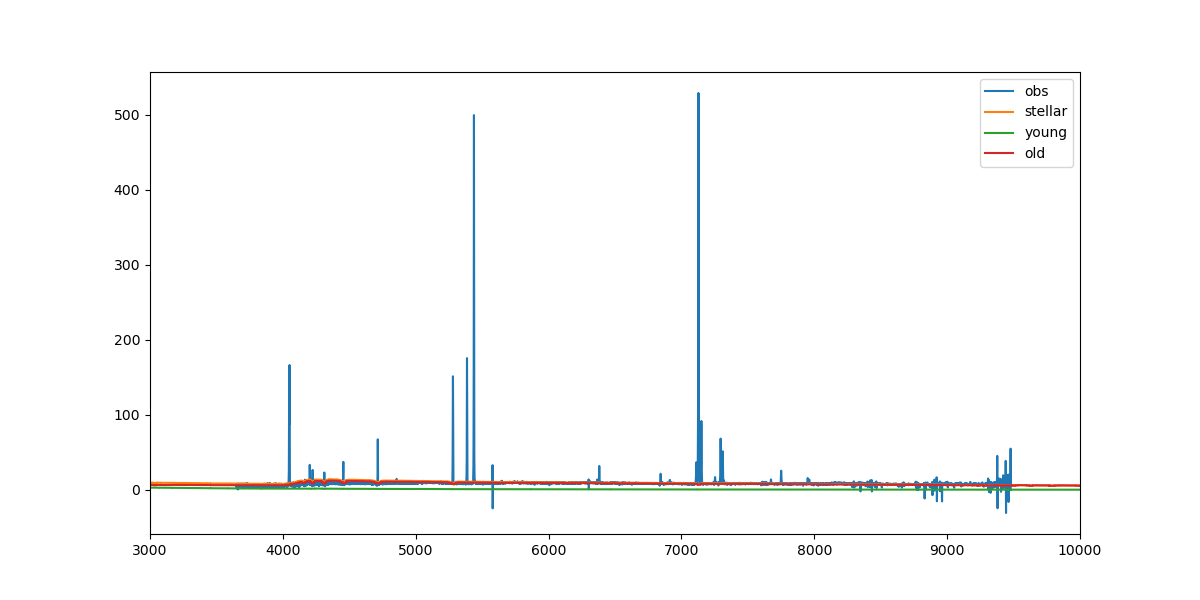

In [155]:
from astropy.io import fits
a = fits.open('/Users/javieratoro/Desktop/proyecto 2024-2/sed_fitting/mage/SFH_const/J0328+0031_best_model.fits')
specs = Table(a[1].data)

wave, flux, _, _ = J0328.datas[0]

# fig,ax=plt.subplots(figsize=(12,8))
# # ax.plot(specs['wavelength'],specs['Fnu'])
# ax.plot(specs['wavelength'],specs['stellar.old'],label='ste.old')
# ax.plot(specs['wavelength'],specs['stellar.young'],label='ste.young')
# ax.set_xlim([300,1000])
# ax.legend()

# fig,ax=plt.subplots(figsize=(12,8))
# # ax.plot(specs['wavelength'],specs['Fnu'])
# ax.plot(specs['wavelength'],specs['attenuation.stellar.old'],label='att.ste.old')
# ax.plot(specs['wavelength'],specs['attenuation.stellar.young'],label='att.ste.young')
# ax.set_xlim([300,1000])
# ax.legend()

# fig,ax=plt.subplots(figsize=(12,8))
# import astropy.units as u
# ax.plot(specs['wavelength'],specs['Fnu'])
# ax.plot(specs['wavelength'],specs['stellar.old']+specs['attenuation.stellar.old'],label='ste.old - att')
# ax.plot(specs['wavelength'],specs['stellar.young']+specs['attenuation.stellar.young'],label='ste.young - att')
# ax.plot(specs['wavelength'],specs['stellar.young']+specs['attenuation.stellar.young']+specs['stellar.old']+specs['attenuation.stellar.old'],label='ste - att')
# ax.set_xlim([300,1000])

# ax.legend()

stellar_spec = specs['stellar.young']+specs['stellar.old']+specs['attenuation.stellar.young']+specs['attenuation.stellar.old']
stellar_spec_norm = stellar_spec / np.median(stellar_spec[(specs['wavelength']>747)&(specs['wavelength']<749)]) * np.median(flux[(wave>7470)&(wave<7490)])
stellar_young_norm = (specs['stellar.young']+specs['attenuation.stellar.young']) / np.median(stellar_spec[(specs['wavelength']>747)&(specs['wavelength']<749)]) * np.median(flux[(wave>7470)&(wave<7490)])
stellar_old_norm = (specs['stellar.old']+specs['attenuation.stellar.old']) / np.median(stellar_spec[(specs['wavelength']>747)&(specs['wavelength']<749)]) * np.median(flux[(wave>7470)&(wave<7490)])


fig,ax=plt.subplots(figsize=(12,6))

ax.plot(wave, flux, label='obs')

ax.plot(specs['wavelength']*10,stellar_spec_norm,label='stellar',drawstyle='steps-mid')
ax.plot(specs['wavelength']*10,stellar_young_norm,label='young',drawstyle='steps-mid')
ax.plot(specs['wavelength']*10,stellar_old_norm,label='old',drawstyle='steps-mid')

ax.set_xlim([3000,10000])
ax.legend()
# stellar_spec_norm
# wave,flux

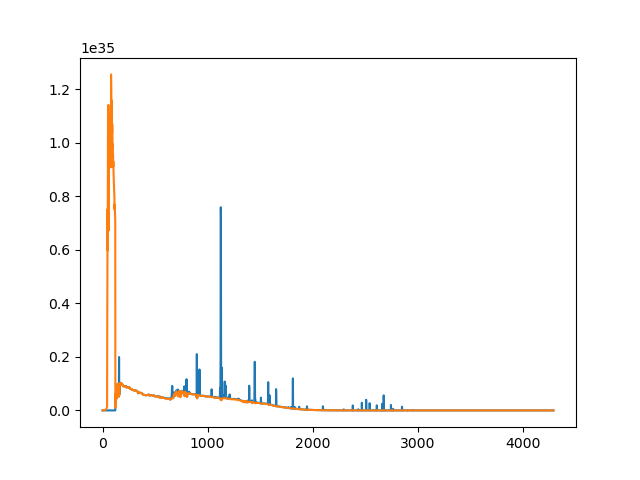

In [152]:
fig = plt.figure()

plt.plot(specs['L_lambda_total'])
plt.plot(stellar_spec)


34.43661665030319 erg / (Angstrom s cm2)
29.530420694835502 erg / (Angstrom s cm2)
28.064074506011593 erg / (Angstrom s cm2)
26.396261621192718 erg / (Angstrom s cm2)
19.999902578728083 erg / (Angstrom s cm2)


/var/folders/b3/z1vmt1t542ncmpppx7tfrqd80000gn/T/ipykernel_2565/3562011112.py:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  phot = pd.read_csv('/Users/javieratoro/Desktop/proyecto 2024-2/sed_fitting/mage/cigale_mage_input.txt', delim_whitespace=True)


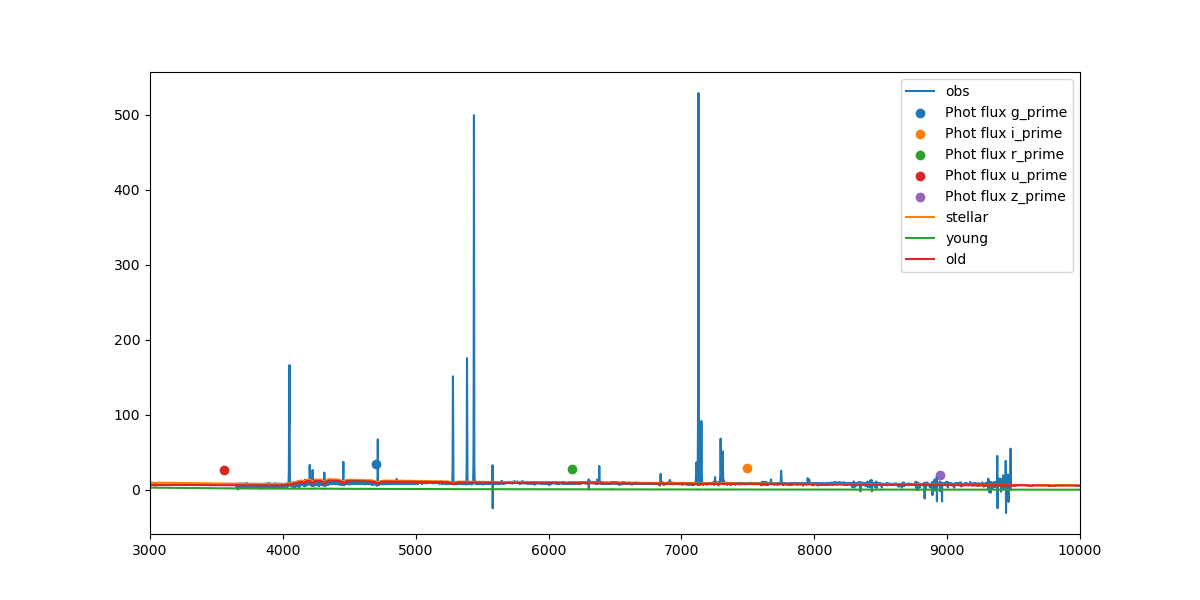

In [133]:
import pyphot
from astropy.table import Table
l = pyphot.get_library()
pivot_wave = {}
for k in sorted(l.content):
        if 'SDSS' in k:
            fk = l[k]
            pivot_wave[fk.name[-1] + '_prime'] = fk.lpivot.value

phot = pd.read_csv('/Users/javieratoro/Desktop/proyecto 2024-2/sed_fitting/mage/cigale_mage_input.txt', delim_whitespace=True)
row = phot.iloc[24]



fig,ax=plt.subplots(figsize=(12,6))

ax.plot(wave, flux, label='obs')
for name in pivot_wave.keys():
      flux_density_mjy = row[name] * u.mJy
      wavelength = pivot_wave[name] * u.Angstrom

      flux_density_cgs = flux_density_mjy.to(u.erg / u.cm**2 / u.s / u.Angstrom,
                                             equivalencies=u.spectral_density(wavelength))/(10 ** -17)
      print(flux_density_cgs)
      ax.scatter(float(pivot_wave[name]), flux_density_cgs, label=f'Phot flux {name}')
ax.plot(specs['wavelength']*10,stellar_spec_norm,label='stellar',drawstyle='steps-mid')
ax.plot(specs['wavelength']*10,stellar_young_norm,label='young',drawstyle='steps-mid')
ax.plot(specs['wavelength']*10,stellar_old_norm,label='old',drawstyle='steps-mid')

ax.set_xlim([3000,10000])
ax.legend()

----------------

Using directory : /Users/javieratoro/Desktop/BAADE_DATA/testing/10-J0020/
New calculated redshift for no_very_flats,  z = 0.10554758939609299
New calculated redshift for twilight,  z = 0.10555114448506375
Plotting for J0020+0030


/var/folders/b3/z1vmt1t542ncmpppx7tfrqd80000gn/T/ipykernel_4169/790386858.py:384: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(constrained_layout=True, figsize=(13, 6))


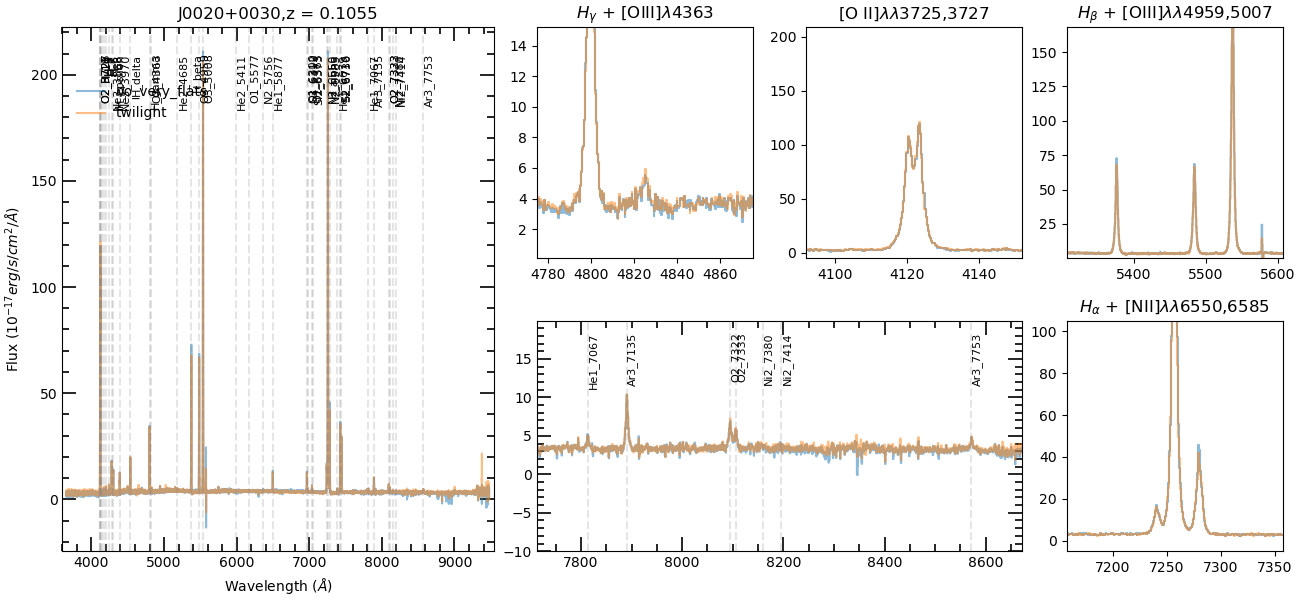

In [46]:
J0020_SPECTRA= {
    'DIR':'/Users/javieratoro/Desktop/BAADE_DATA/testing/10-J0020/',
    'FILES': ['no_very_flats/J0020_NO_VERY_FLATS_tellcorr.fits', 'twilight/J0020_TWILIGHT_tellcorr.fits'],
     'redshift': 0.106,
     'names':['J0020+0030'],
     'mass':9.6
}
J0020 = REDUC_LINES(J0020_SPECTRA)
J0020.plot_spectra()

Using directory : /Users/javieratoro/Desktop/BAADE_DATA/testing/7-J2336/
New calculated redshift for no_very_flats,  z = 0.17049011519054413
New calculated redshift for twilight,  z = 0.17052980472077195
Plotting for J2336-0042


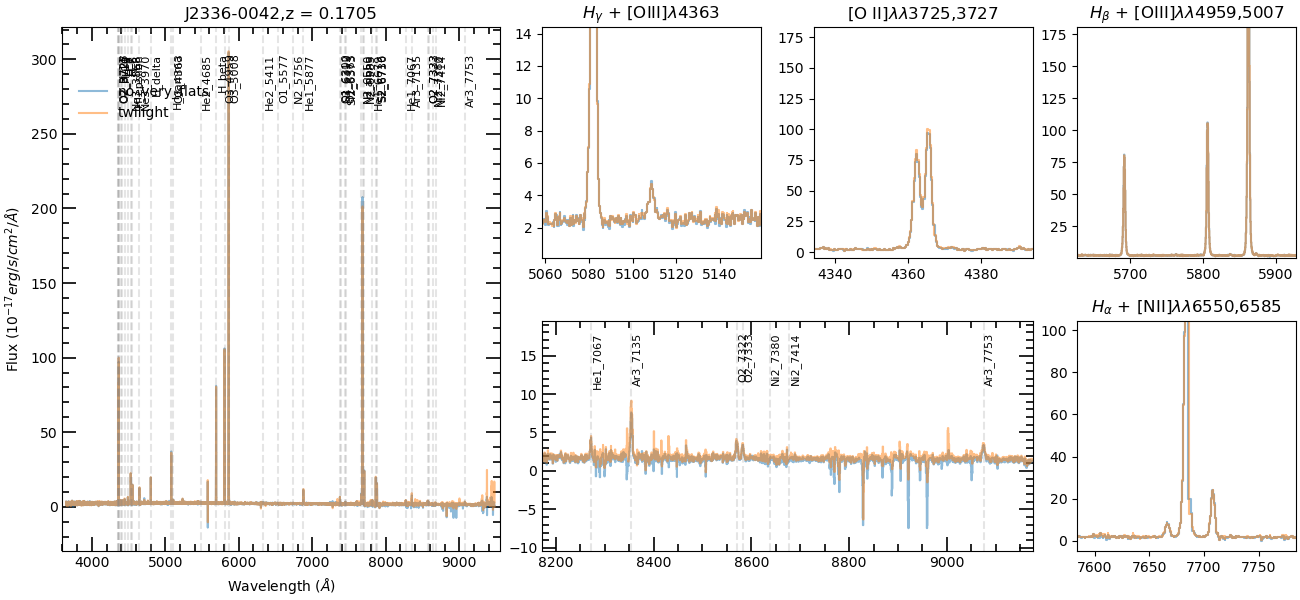

In [32]:
J2336_SPECTRA= {
    'DIR':'/Users/javieratoro/Desktop/BAADE_DATA/testing/7-J2336/',
    'FILES': [ 'no_very_flats/J2336_NO_VERY_BLUE_tellcorr.fits', 'twilight/J2336_TWILIGHT_tellcorr.fits'],
    'redshift':0.17047114835326904,
    'names':['J2336-0042'],
    'mass':9.9
}
J2336 = REDUC_LINES(J2336_SPECTRA)
J2336.plot_spectra()

Using directory : /Users/javieratoro/Desktop/BAADE_DATA/testing/6-J2258/
New calculated redshift for no_very_flats,  z = 0.09403516913892773
New calculated redshift for twilight,  z = 0.09401221176250396
Plotting for J2258+0056


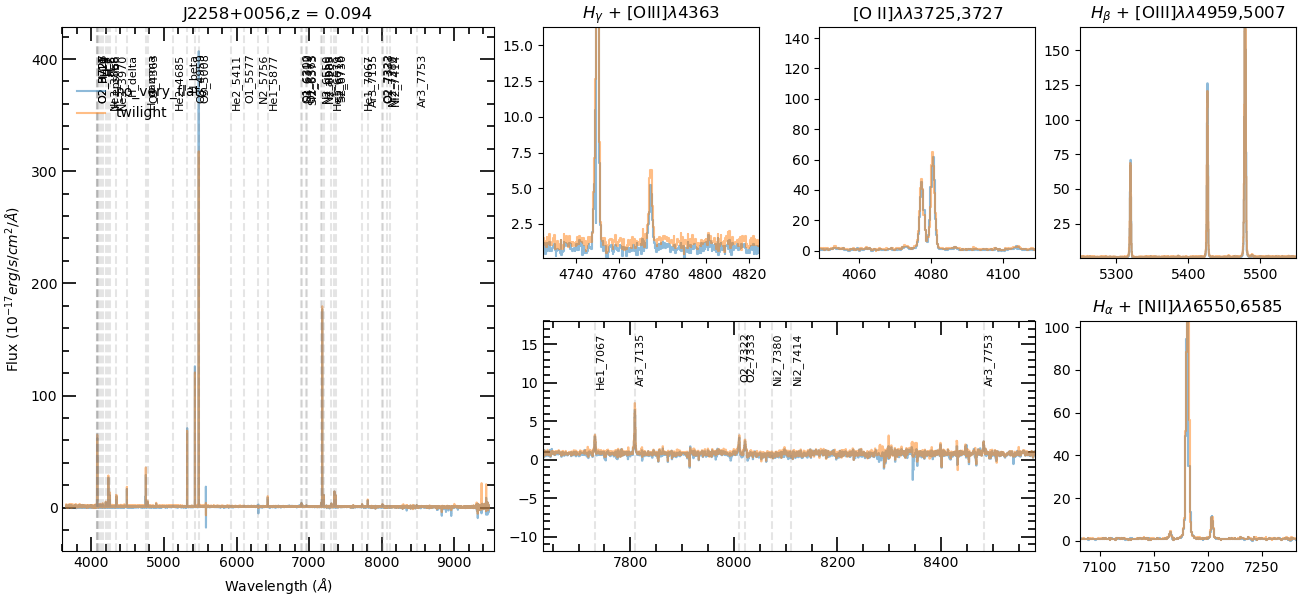

/opt/anaconda3/envs/pypeit/lib/python3.11/site-packages/ipympl/backend_nbagg.py:279: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  self.manager.handle_json(content)


In [24]:
J2258_SPECTRA= {
    'DIR':'/Users/javieratoro/Desktop/BAADE_DATA/testing/6-J2258/',
    'FILES': ['no_very_flats/J2258_NO_VERY_FLATS_tellcorr.fits', 'twilight/J2258_TWILIGHT_tellcorr.fits'],
     'redshift': 0.094,
     'names':['J2258+0056'],
     'mass':9.6
}
J2258 = REDUC_LINES(J2258_SPECTRA)
J2258.plot_spectra()
# J2258.plot_fit(True, broad=False)
# J2258.fit_MC(100)

Using directory : /Users/javieratoro/Desktop/BAADE_DATA/testing/2-J2204/
New calculated redshift for no_very_flats,  z = 0.18498486267768566
New calculated redshift for twilight,  z = 0.1849716625542437
Plotting for J2204+0058


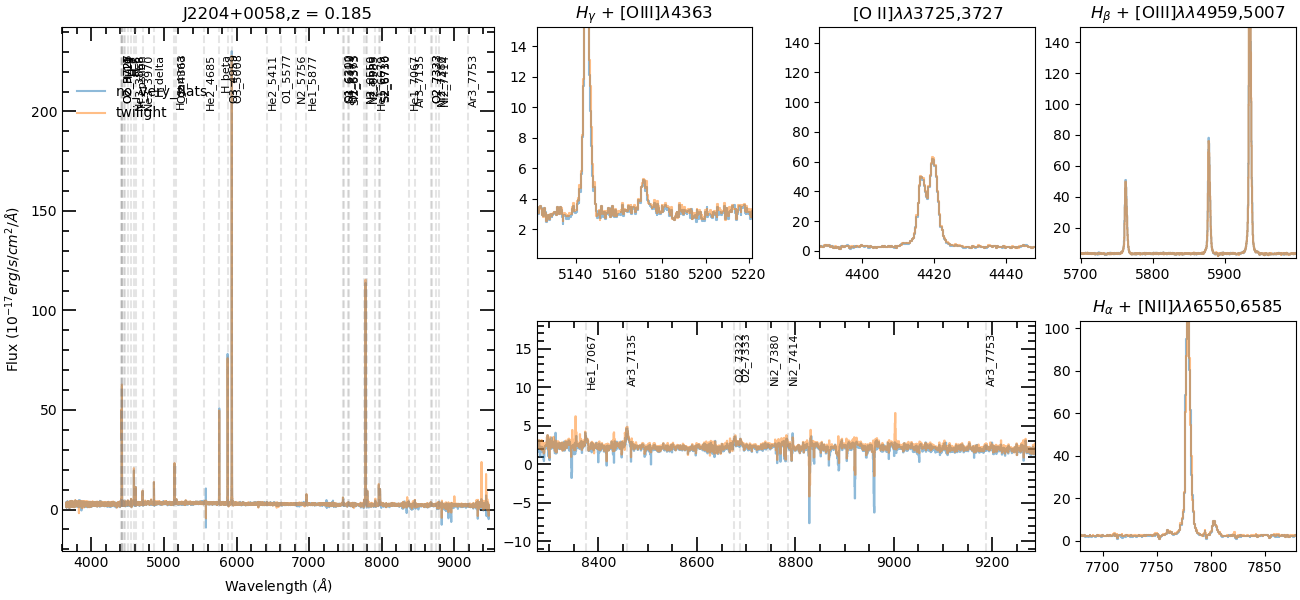

/opt/anaconda3/envs/pypeit/lib/python3.11/site-packages/ipympl/backend_nbagg.py:279: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  self.manager.handle_json(content)


In [26]:
J2204_SPECTRA= {
    'DIR':'/Users/javieratoro/Desktop/BAADE_DATA/testing/2-J2204/',
    'FILES': ['no_very_flats/J2204_NO_VERY_tellcorr.fits', 'twilight/J2204_TWILIGHT_tellcorr.fits'],
     'redshift': 0.185,
     'names':['J2204+0058'],
     'mass':10.16
}
J2204 = REDUC_LINES(J2204_SPECTRA)
J2204.plot_spectra()
# J2204.plot_fit(False)
#J2204.fit_MC(100)

Using directory : /Users/javieratoro/Desktop/BAADE_DATA/testing/25-J0203/
New calculated redshift for no_very_flats,  z = 0.1561913277477155
New calculated redshift for twilight,  z = 0.15611784420111452
Plotting for J0203+0035


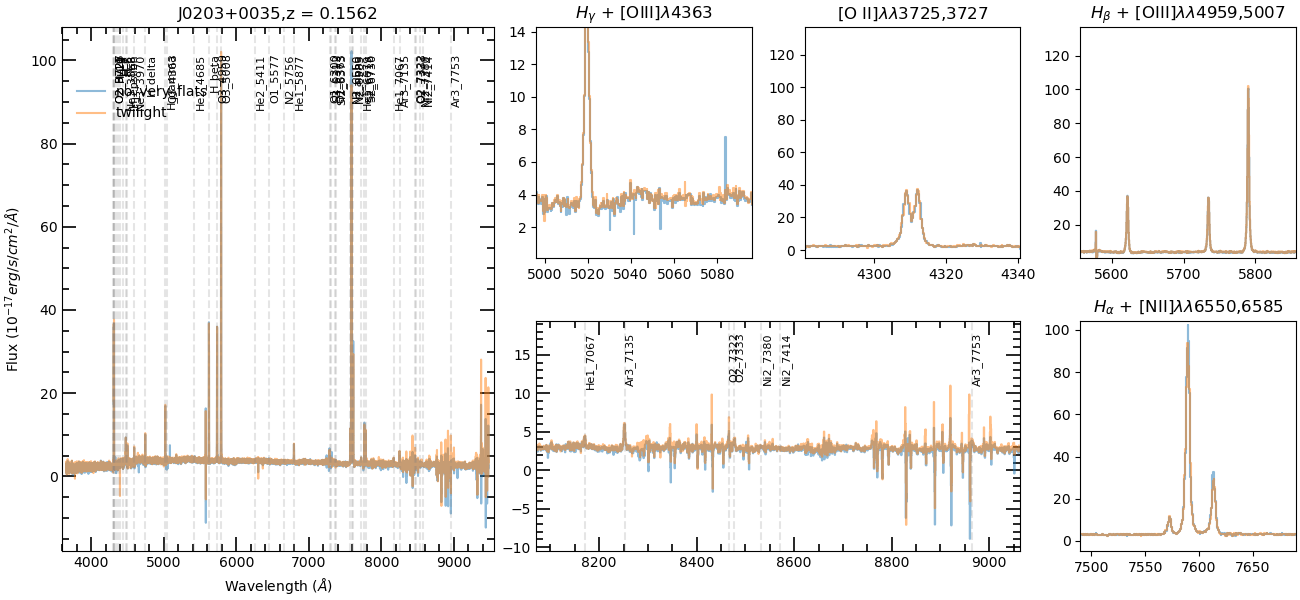

/opt/anaconda3/envs/pypeit/lib/python3.11/site-packages/ipympl/backend_nbagg.py:279: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  self.manager.handle_json(content)


In [27]:
J0203_SPECTRA= {
    'DIR':'/Users/javieratoro/Desktop/BAADE_DATA/testing/25-J0203/',
    'FILES': ['no_very_flats/J0203_NO_VERY_FLATS_tellcorr.fits', 'twilight/J0203_TWILIGHT_tellcorr.fits'],
     'redshift': 0.156,
     'names':['J0203+0035'],
     'mass':9.96
}
J0203 = REDUC_LINES(J0203_SPECTRA)
J0203.plot_spectra()
# J0203.plot_fit(True)
# J0203.fit_MC(100)

Using directory : /Users/javieratoro/Desktop/BAADE_DATA/testing/28-J0243/
New calculated redshift for no_very_flats,  z = 0.13436783505840433
New calculated redshift for twilight,  z = 0.13442118111394386
Plotting for J0243+0111


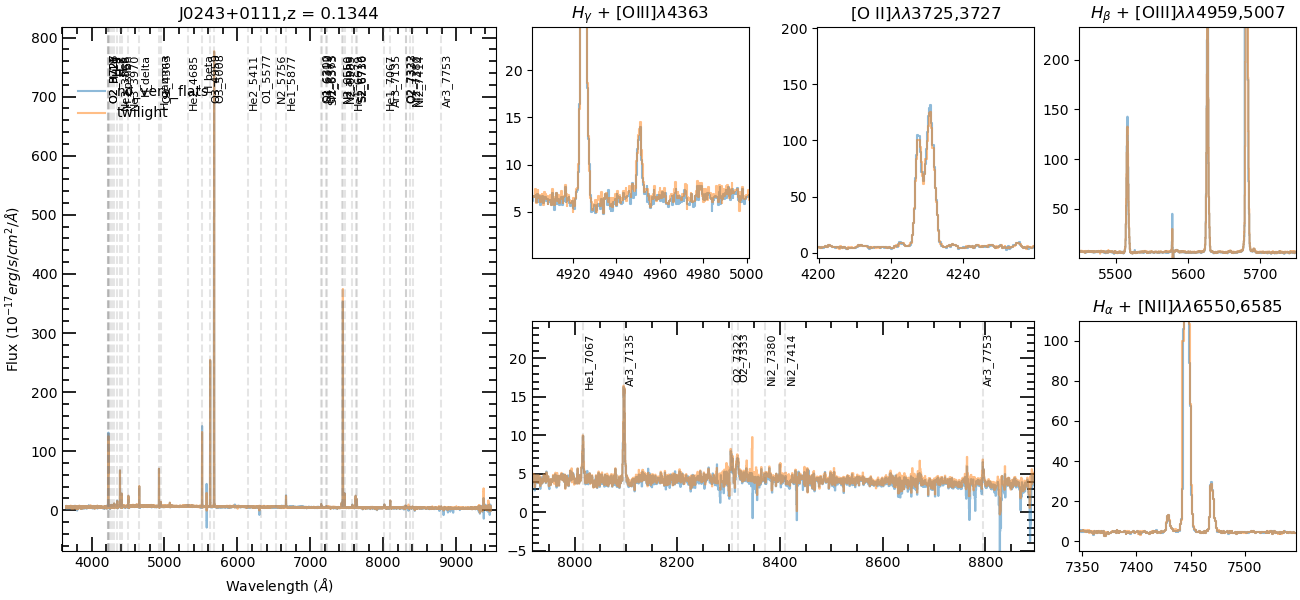

/opt/anaconda3/envs/pypeit/lib/python3.11/site-packages/ipympl/backend_nbagg.py:279: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  self.manager.handle_json(content)


In [28]:
J0243_SPECTRA= {
    'DIR':'/Users/javieratoro/Desktop/BAADE_DATA/testing/28-J0243/',
    'FILES': ['no_very_flats/J0243_NO_VERY_FLATS_tellcorr.fits', 'twilight/J0243_TWILIGHT_tellcorr.fits'],
     'redshift': 0.134,
     'names':['J0243+0111'],
     'mass':9.7
}
J0243 = REDUC_LINES(J0243_SPECTRA)
J0243.plot_spectra()
# J0243.plot_fit(True, broad=True)
# J0243.fit_MC(100)

Using directory : /Users/javieratoro/Desktop/BAADE_DATA/testing/35-J0328/
New calculated redshift for no_very_flats,  z = 0.08586139932076653
New calculated redshift for twilight,  z = 0.08576768925865552
Plotting for J0328+0031


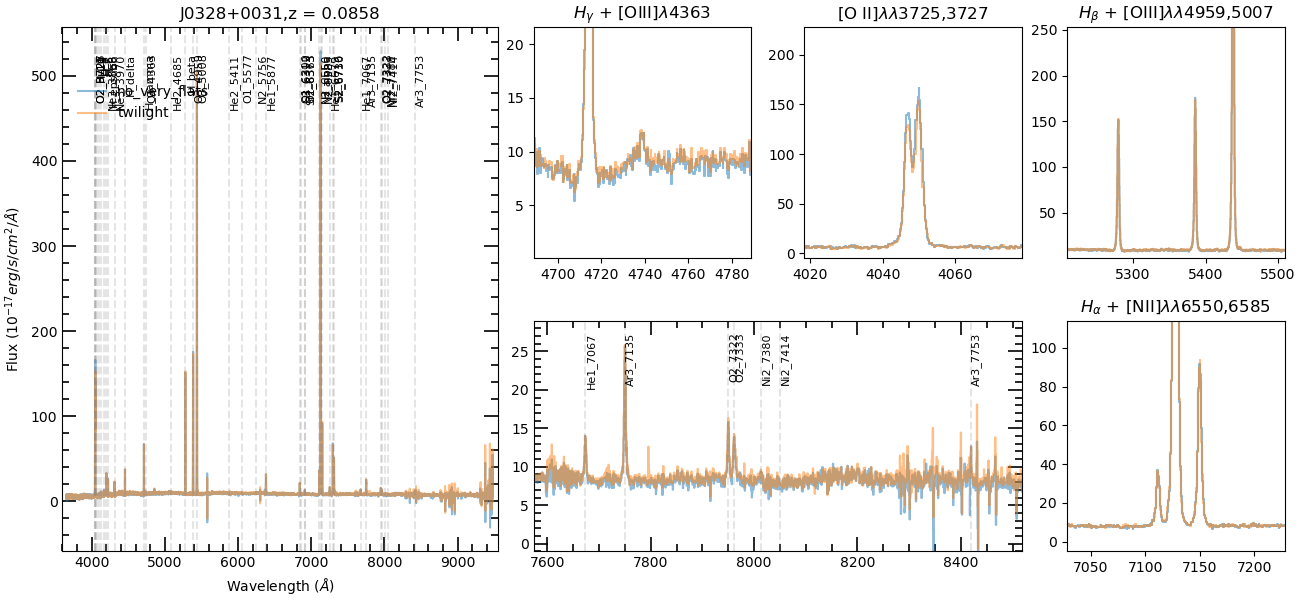

In [29]:
J0328_SPECTRA= {
    'DIR':'/Users/javieratoro/Desktop/BAADE_DATA/testing/35-J0328/',
    'FILES': ['no_very_flats/J0328_NO_VERY_FLATS_tellcorr.fits', 'twilight/J0328_TWILIGHT_tellcorr.fits'],
     'redshift': 0.086,
     'names':['J0328+0031'],
     'mass':9.8
}
J0328 = REDUC_LINES(J0328_SPECTRA)
J0328.plot_spectra()
# J0328.plot_fit(True)
# J0328.fit_MC(100)

Using directory : /Users/javieratoro/Desktop/BAADE_DATA/testing/36-J0033/
New calculated redshift for no_very_flats,  z = 0.19381676607842624
New calculated redshift for twilight,  z = 0.1938091481100721
Plotting for J0333+0017


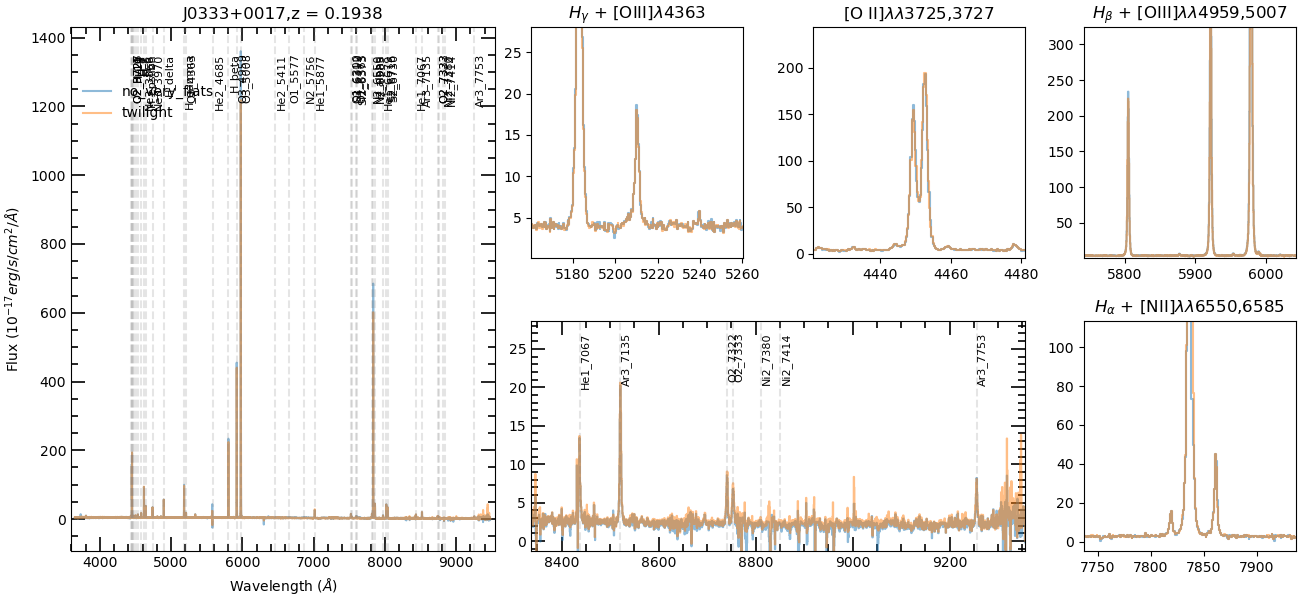

/opt/anaconda3/envs/pypeit/lib/python3.11/site-packages/ipympl/backend_nbagg.py:279: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  self.manager.handle_json(content)


In [30]:
J0333_SPECTRA= {
    'DIR':'/Users/javieratoro/Desktop/BAADE_DATA/testing/36-J0033/',
    'FILES': ['no_very_flats/J0033_NO_VERY_FLATS_tellcorr.fits', 'twilight/J0033_TWILIGHT_tellcorr.fits'],
     'redshift': 0.194,
     'names':['J0333+0017'],
     'mass':9.9
}
J0333 = REDUC_LINES(J0333_SPECTRA)
J0333.plot_spectra()
# J0333.plot_fit(True)
# J0333.fit_MC(100)

Using directory : /Users/javieratoro/Desktop/BAADE_DATA/testing/38-J0404/
New calculated redshift for no_very_flats,  z = 0.06580612935062868
New calculated redshift for twilight,  z = 0.06573682948807902
Plotting for J0404+0538


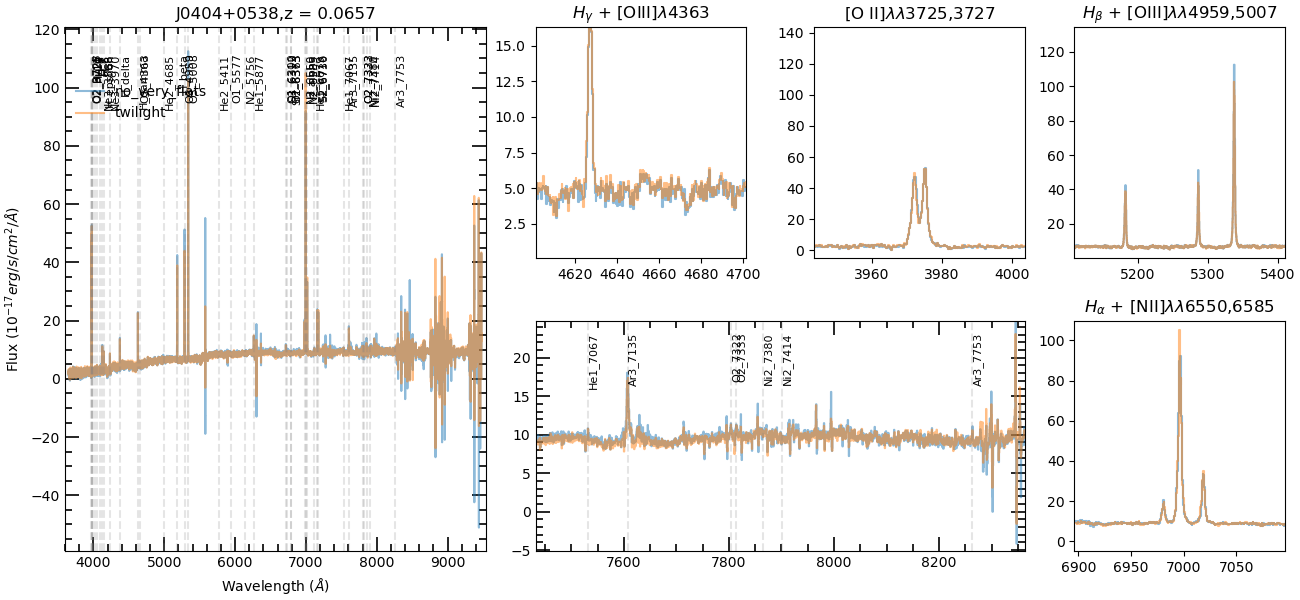

In [31]:
J0404_SPECTRA= {
    'DIR':'/Users/javieratoro/Desktop/BAADE_DATA/testing/38-J0404/',
    'FILES': ['no_very_flats/J0404_NO_VERY_FLATS_tellcorr.fits', 'twilight/J0404_TWILIGHT_tellcorr.fits'],
     'redshift': 0.066,
     'names':['J0404+0538'],
     'mass':10.2
}
J0404 = REDUC_LINES(J0404_SPECTRA)
J0404.plot_spectra()
# J0404.plot_fit(True, broad=True)
# J0404.fit_MC(100)


# -------

In [ ]:


J2258_SPECTRA= {
    'DIR':'/Users/javieratoro/Desktop/BAADE_DATA/testing/6-J2258/',
    'FILES': ['no_very_flats/J2258_NO_VERY_FLATS_tellcorr.fits', 'twilight/J2258_TWILIGHT_tellcorr.fits'],
     'redshift': 0.094,
     'names':['J2258+0056'],
     'mass':9.6
}
J2258 = reduc_tryoff(J2258_SPECTRA)

J0020_SPECTRA= {
    'DIR':'/Users/javieratoro/Desktop/BAADE_DATA/testing/10-J0020/',
    'FILES': ['no_very_flats/J0020_NO_VERY_FLATS_tellcorr.fits', 'twilight/J0020_TWILIGHT_tellcorr.fits'],
     'redshift': 0.106,
     'names':['J0020+0030'],
     'mass':9.6
}
J0020 = reduc_tryoff(J0020_SPECTRA)

J0203_SPECTRA= {
    'DIR':'/Users/javieratoro/Desktop/BAADE_DATA/testing/25-J0203/',
    'FILES': ['no_very_flats/J0203_NO_VERY_FLATS_tellcorr.fits', 'twilight/J0203_TWILIGHT_tellcorr.fits'],
     'redshift': 0.156,
     'names':['J0203+0035'],
     'mass':9.96
}
J0203 = reduc_tryoff(J0203_SPECTRA)

J0243_SPECTRA= {
    'DIR':'/Users/javieratoro/Desktop/BAADE_DATA/testing/28-J0243/',
    'FILES': ['no_very_flats/J0243_NO_VERY_FLATS_tellcorr.fits', 'twilight/J0243_TWILIGHT_tellcorr.fits'],
     'redshift': 0.134,
     'names':['J0243+0111'],
     'mass':9.7
}
J0243 = reduc_tryoff(J0243_SPECTRA)

J0328_SPECTRA= {
    'DIR':'/Users/javieratoro/Desktop/BAADE_DATA/testing/35-J0328/',
    'FILES': ['no_very_flats/J0328_NO_VERY_FLATS_tellcorr.fits', 'twilight/J0328_TWILIGHT_tellcorr.fits'],
     'redshift': 0.086,
     'names':['J0328+0031'],
     'mass':9.8
}
J0328 = reduc_tryoff(J0328_SPECTRA)

J0033_SPECTRA= {
    'DIR':'/Users/javieratoro/Desktop/BAADE_DATA/testing/36-J0033/',
    'FILES': ['no_very_flats/J0033_NO_VERY_FLATS_tellcorr.fits', 'twilight/J0033_TWILIGHT_tellcorr.fits'],
     'redshift': 0.194,
     'names':['J0333+0017'],
     'mass':9.9
}
J0033 = reduc_tryoff(J0033_SPECTRA)

J0404_SPECTRA= {
    'DIR':'/Users/javieratoro/Desktop/BAADE_DATA/testing/38-J0404/',
    'FILES': ['no_very_flats/J0404_NO_VERY_FLATS_tellcorr.fits', 'twilight/J0404_TWILIGHT_tellcorr.fits'],
     'redshift': 0.066,
     'names':['J0404+0538'],
     'mass':10.2
}
J0404 = reduc_tryoff(J0404_SPECTRA)

In [ ]:
dictionaries = [J2204, J0020, J0033, J0203, J0243, J0328, J0404, J2258, J2336]
rows = []

for i in dictionaries:
    df2 = pd.read_csv('/Users/javieratoro/Desktop/proyecto 2024-2/lines/v1/' + name + '.csv')

    new_row = {
    'ID': i.names[0],
    'z': i.redshift,
    'mass': i.mass }

    for label in i.linelist_dict.keys():
        mask = (df2['name'] == label)
        flux, fluxerr = df2.loc[mask, ['flux', 'fluxerr']].values[0]
        new_row[label + '_flux'] = flux
        new_row[label + '_fluxerr'] = fluxerr

    rows.append(new_row)

df = pd.DataFrame(rows)
df.to_csv('/Users/javieratoro/Desktop/proyecto 2024-2/magE_2024.csv')

df

In [ ]:
import os
import pandas as pd

path = '/Users/javieratoro/Desktop/proyecto 2024-2/lines'

contents = os.listdir(path)
rows = []
for item in contents:
    if '.csv' in item and '_model.csv' not in item:
        df = pd.read_csv(f'{path}/{item}')
        new_row = {
        'ID': df['ID'][0],
        'z': float(df['z'][0]),
        'mass': float(df['mass'][0]) }

        for label in df['name']:
            mask = (df['name'] == label)
            flux, fluxerr = df.loc[mask, ['flux', 'fluxerr']].values[0]
            new_row[label + '_flux'] = flux
            new_row[label + '_fluxerr'] = fluxerr

        rows.append(new_row)

df2 = pd.DataFrame(rows)
df2.to_csv('/Users/javieratoro/Desktop/proyecto 2024-2/magE_2024.csv')

In [ ]:
df

In [ ]:
df2